# Introduction

In this notebook, I directly try to do a hierarchical classification based on the pytorch-based library:
https://github.com/Tencent/NeuralNLP-NeuralClassifier

Paper:
https://aclanthology.org/P19-3015/

## Observation

- We are able to generate the label taxonomy compatible for the framework
- We are also able to generate the compatible data
- On a prelimiary **Transformer-based** training, we are able to get a decent classifier within 25 epochs.
- The macro-level metric might be lower because of the skewness of the class distribution.

> See the final section where I also evaluate a jaccard-based metric

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [3]:
DRIVE_BASE = "/content/drive/MyDrive/Colab Notebooks/uah-ra/"

In [7]:
KW_PATH = os.path.join(DRIVE_BASE, "data/keywords.txt")
DATA_PATH = os.path.join(DRIVE_BASE, "data/data.csv")

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [9]:
def load_keywords(path):
    res = []
    with open(path) as f:
        text = f.read().strip()
        tags_str = text.split(",")
        res = map(lambda t: [_.strip().lower() for _ in t.split(">")], tags_str)
        res = filter(lambda x: len(x) > 0, res)
        res = list(res)
    return res

In [10]:
KEYWORDS = load_keywords(KW_PATH)
len(KEYWORDS), len(set([kw for kws in KEYWORDS for kw in kws]))

(1654, 1320)

In [12]:
KEYWORDS[:5]

[['earth science',
  'terrestrial hydrosphere',
  'surface water',
  'surface water processes/measurements',
  'discharge/flow'],
 ['earth science',
  'terrestrial hydrosphere',
  'surface water',
  'surface water processes/measurements',
  'hydropattern'],
 ['earth science',
  'terrestrial hydrosphere',
  'surface water',
  'surface water processes/measurements',
  'stage height'],
 ['earth science', 'solid earth', 'rocks/minerals', 'age determinations'],
 ['earth science', 'cryosphere', 'sea ice', 'ice depth/thickness', 'depth']]

# Tag Analysis

In [13]:
!pip install loguru

     |████████████████████████████████| 57 kB 3.1 MB/s 


In [14]:
from loguru import logger

In [15]:
from collections import Counter, defaultdict

In [16]:
def get_counts(keywords, level=0):
    kws = map(lambda x: x[level if level<len(x) else len(x)-1], keywords)
    kws = list(kws)
    # kws = list(map(str.lower, kws))
    counter = Counter(kws)
    return counter

In [17]:
def analyze_kws(keywords, topn=10):
    plt.figure(figsize=(15, 8))
    for level in [0, 1, 2, 3, -1]:
        _ = get_counts(KEYWORDS, level=level)
        logger.debug(f"[Level={level}, NKWs={len(_)}] : {_.most_common(10)}")
        df = pd.DataFrame(_.most_common(topn), columns=["kw", "frequency"])
        ax = sns.barplot(
            x="frequency", y="kw",
            data=df,
            linewidth=2.5,
            facecolor=(1, 1, 1, 0),
            errcolor=".2",
            edgecolor=".2"
        )
        plt.title(f"Level={level}, topn={topn}")
        plt.figure(figsize=(15, 8))

In [18]:
", ".join(list(get_counts(KEYWORDS, level=1).keys()))

'terrestrial hydrosphere, solid earth, cryosphere, human dimensions, atmosphere, biological classification, biosphere, land surface, oceans, agriculture, climate indicators, paleoclimate, spectral/engineering, sun-earth interactions, hydrosphere, environmental advisories, not provided, none, spectral engineering, breakup date, ice duration, data analysis and visualization, photograph, ocean optics, surface, and internal layer geometry, nasa decadal survey, active remote sensing, timing'

2021-07-30 08:23:16.840 | DEBUG    | __main__:analyze_kws:5 - [Level=0, NKWs=10] : [('earth science', 1645), ('breakup date', 1), ('ice duration', 1), ('oceans', 1), ('surface', 1), ('and internal layer geometry', 1), ('earth observation satellites', 1), ('earth remote sensing instruments', 1), ('earth science services', 1), ('timing', 1)]
2021-07-30 08:23:16.890 | DEBUG    | __main__:analyze_kws:5 - [Level=1, NKWs=29] : [('atmosphere', 422), ('oceans', 202), ('land surface', 160), ('cryosphere', 148), ('biosphere', 118), ('terrestrial hydrosphere', 117), ('spectral/engineering', 95), ('human dimensions', 85), ('biological classification', 83), ('agriculture', 65)]
2021-07-30 08:23:16.971 | DEBUG    | __main__:analyze_kws:5 - [Level=2, NKWs=141] : [('snow/ice', 105), ('soils', 92), ('sea ice', 81), ('animals/vertebrates', 70), ('clouds', 62), ('atmospheric chemistry', 61), ('atmospheric radiation', 51), ('glaciers/ice sheets', 44), ('aerosols', 44), ('atmospheric winds', 42)]
2021-07-3

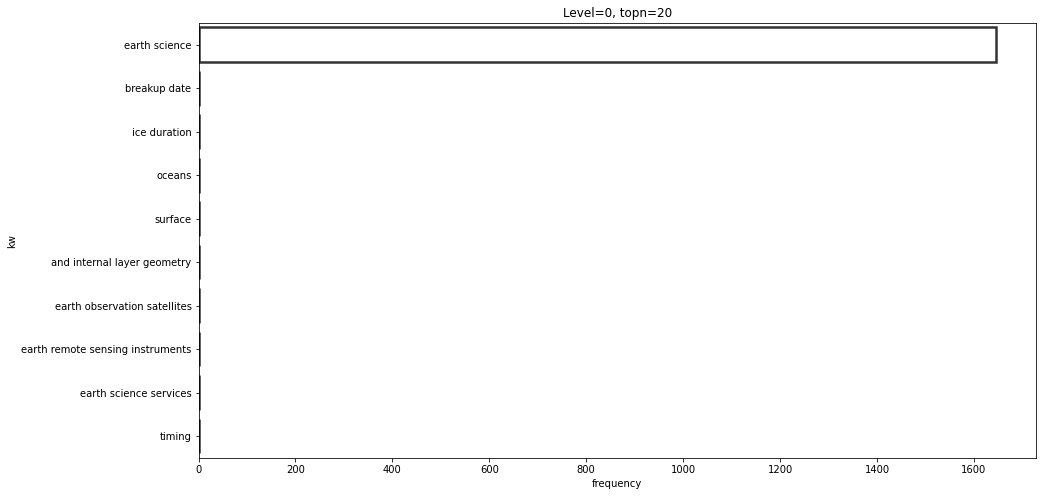

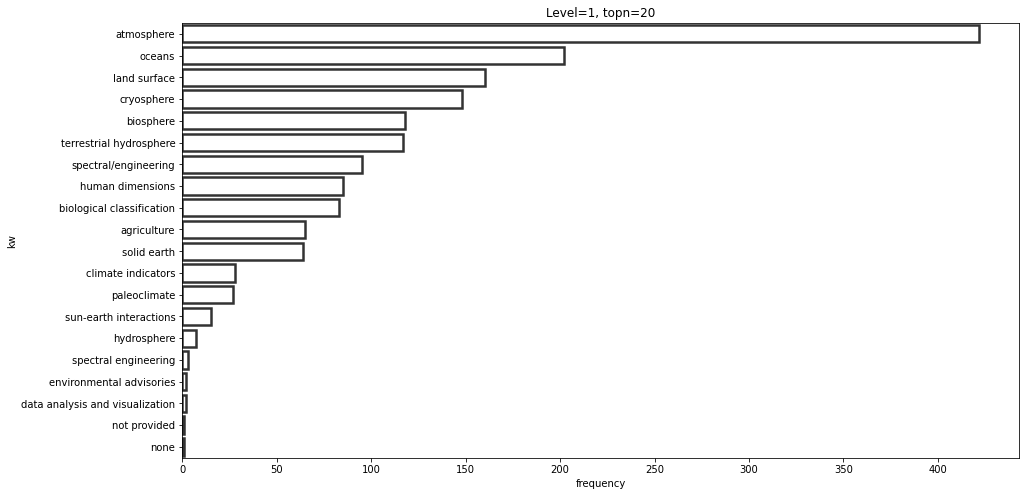

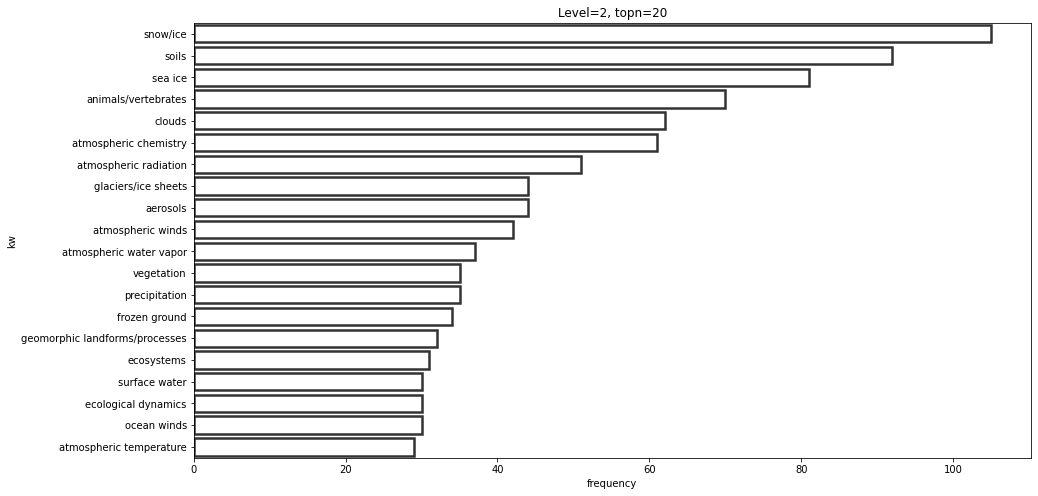

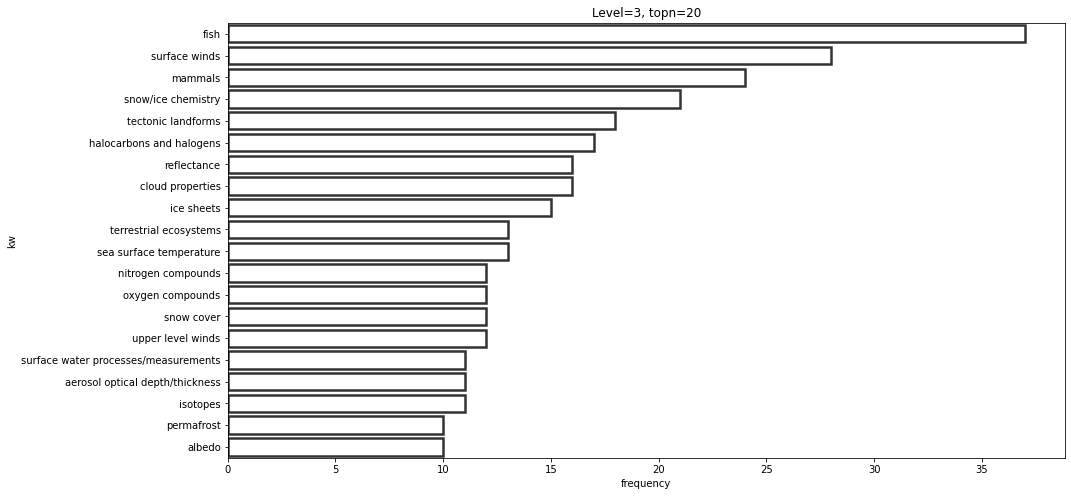

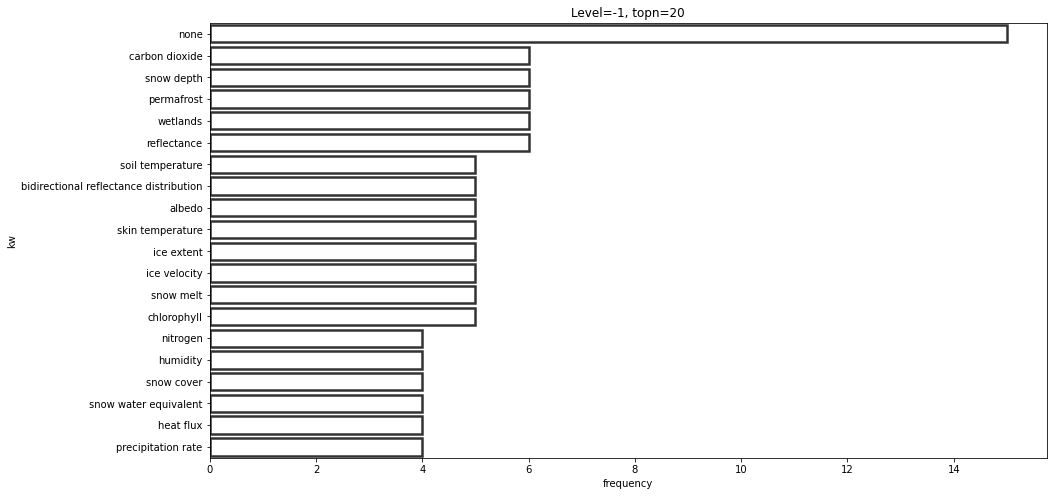

<Figure size 1080x576 with 0 Axes>

In [19]:
analyze_kws(KEYWORDS, topn=20)

# Data Analysis

In [20]:
def parse_kws(kw_str, level=2):
    res = kw_str.split(",")
    res = map(lambda kw: [_.strip().lower() for _ in kw.split(">")], res)
    res = map(lambda x: x[level if level<len(x) else len(x)-1], res)
    return list(set(res))

def load_data(path, level=0):
    logger.info(f"Loading data from {path}. [KW Level={level}]")
    df = pd.read_csv(path)
    df["desc"] = df["desc"].apply(str.strip)
    df["labels"] = df["keywords"].apply(lambda x: parse_kws(x, level))
    df["textlen"] = df["desc"].apply(len)
    return df

In [21]:
DATA = load_data(DATA_PATH, level=1)

2021-07-30 08:23:20.700 | INFO     | __main__:load_data:8 - Loading data from /content/drive/MyDrive/Colab Notebooks/uah-ra/data/data.csv. [KW Level=1]


In [22]:
DATA.shape

(5999, 4)

In [23]:
DATA.head(10)

,desc,keywords,labels,textlen
0,USGS 15 minute stream flow data for Kings Cree...,EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURF...,[terrestrial hydrosphere],68
1,"This data set contains the VSMOW-SLAP d17O, d1...",EARTH SCIENCE > Solid Earth > Rocks/Minerals >...,"[solid earth, cryosphere]",425
2,Digital line graph (DLG) data are digital repr...,EARTH SCIENCE > HUMAN DIMENSIONS > BOUNDARIES ...,"[human dimensions, terrestrial hydrosphere]",751
3,The 2000 Pilot Environmental Sustainability In...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[biological classification, atmosphere, human ...",956
4,The 2001 Environmental Sustainability Index (E...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[biological classification, atmosphere, human ...",989
5,The 2002 Environmental Sustainability Index (E...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[biological classification, atmosphere, oceans...",760
6,The 2005 Environmental Sustainability Index (E...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[biological classification, atmosphere, human ...",940
7,The 2008 Environmental Performance Index (EPI)...,EARTH SCIENCE > AGRICULTURE > AGRICULTURAL AQU...,"[human dimensions, agriculture, atmosphere, bi...",1504
8,The 2010 Environmental Performance Index (EPI)...,EARTH SCIENCE > AGRICULTURE > AGRICULTURAL AQU...,"[human dimensions, agriculture, atmosphere, bi...",852
9,The 2012 Environmental Performance Index (EPI)...,EARTH SCIENCE > AGRICULTURE > AGRICULTURAL AQU...,"[human dimensions, agriculture, atmosphere, bi...",1402


In [24]:
def analyze_labels(df):
    df = df.copy()
    labels = [l for ls in df["labels"] for l in ls]
    uniques = set(labels)
    logger.info(f"{len(uniques)} unique labels")

In [25]:
analyze_labels(DATA)

2021-07-30 08:23:38.809 | INFO     | __main__:analyze_labels:5 - 29 unique labels


In [26]:
# idx = 2
# _data.iloc[2].keywords_processed

In [27]:
_data = DATA.copy()
_data = _data[_data["textlen"]>0]

In [28]:
_data.shape

(5999, 4)

In [29]:
# BERT can only process 512 tokens at once
len(_data[_data["textlen"] <= 512]) / len(_data), len(_data[_data["textlen"] <= 1024]) / len(_data)

(0.3295549258209702, 0.6309384897482914)

[(0.0, 3000.0)]

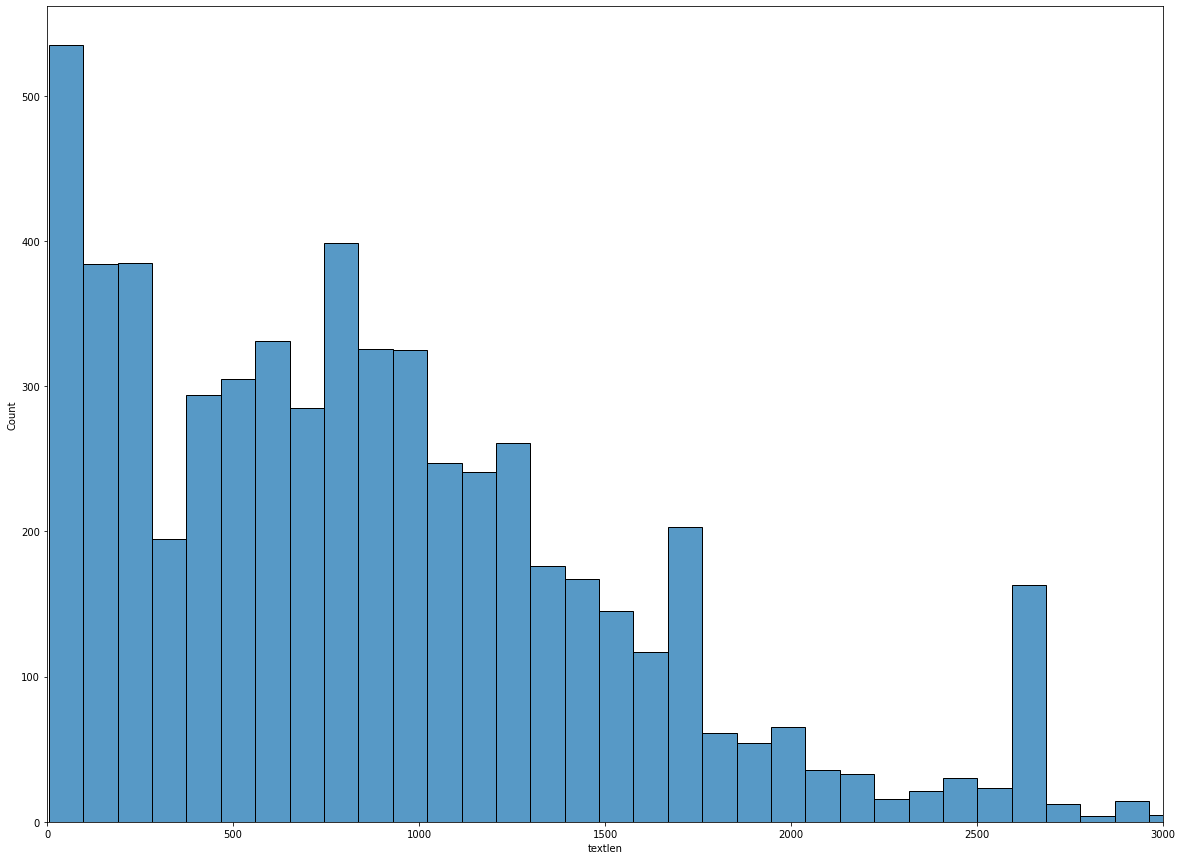

In [30]:
plt.figure(figsize=(20, 15))
sns.histplot(data=_data, x="textlen", bins=100).set(xlim=(0, 3000))

# Prepare Dataset

In [32]:
DATA_TO_USE = DATA.copy()
# DATA_TO_USE = DATA_TO_USE[DATA_TO_USE["textlen"]<=500]

In [33]:
DATA_TO_USE.shape

(5999, 4)

In [34]:
DATA_TO_USE.head()

,desc,keywords,labels,textlen
0,USGS 15 minute stream flow data for Kings Cree...,EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURF...,[terrestrial hydrosphere],68
1,"This data set contains the VSMOW-SLAP d17O, d1...",EARTH SCIENCE > Solid Earth > Rocks/Minerals >...,"[solid earth, cryosphere]",425
2,Digital line graph (DLG) data are digital repr...,EARTH SCIENCE > HUMAN DIMENSIONS > BOUNDARIES ...,"[human dimensions, terrestrial hydrosphere]",751
3,The 2000 Pilot Environmental Sustainability In...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[biological classification, atmosphere, human ...",956
4,The 2001 Environmental Sustainability Index (E...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[biological classification, atmosphere, human ...",989


In [35]:
analyze_labels(DATA_TO_USE)

2021-07-30 08:24:02.691 | INFO     | __main__:analyze_labels:5 - 29 unique labels


# Generate Dataset
Compatible to the library format

## Split Dataset

In [43]:
from sklearn.model_selection import train_test_split

In [99]:
#  X_train, X_test, Y_train, Y_test = train_test_split(DATA_TO_USE["desc"].to_numpy(), LABELS_ENCODED, test_size=0.1, random_state=42)
DATA_TRAIN, DATA_TEST = train_test_split(DATA_TO_USE, test_size=0.1, random_state=42)

#  X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [100]:
DATA_TRAIN.head()

,desc,keywords,labels,textlen
4532,This dataset contains ocean surface Eastward w...,EARTH SCIENCE > OCEANS > OCEAN WINDS > SURFACE...,[oceans],177
907,This data set provides data for MODIS-derived ...,EARTH SCIENCE > BIOSPHERE > VEGETATION > PHOTO...,"[climate indicators, biosphere, oceans]",702
1918,This data set contains geolocated surface elev...,EARTH SCIENCE > Cryosphere > Glaciers/Ice Shee...,[cryosphere],558
1488,This dataset is the GPM Level 3 IMERG *Early*...,"EARTH SCIENCE > ATMOSPHERE > PRECIPITATION,EAR...",[atmosphere],5546
2721,ML2IWC is the EOS Aura Microwave Limb Sounder ...,EARTH SCIENCE > ATMOSPHERE > CLOUDS > CLOUD MI...,[atmosphere],901


# Install Library

In [47]:
!git clone https://github.com/Tencent/NeuralNLP-NeuralClassifier

Cloning into 'NeuralNLP-NeuralClassifier'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 161 (delta 17), reused 18 (delta 5), pack-reused 115
Receiving objects: 100% (161/161), 26.26 MiB | 17.33 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [48]:
%cd "/content/NeuralNLP-NeuralClassifier"

/content/NeuralNLP-NeuralClassifier


In [49]:
!ls

conf	   eval.py			     predict.py        train.py
config.py  evaluate			     readme	       util.py
data	   License_for_NeuralClassifier.TXT  README.md
dataset    model			     requirements.txt


In [50]:
! pip install -r requirements.txt

In [56]:
! python train.py conf/train.hierar.json

Use dataset to generate dict.
Size of doc_label dict is 102
Size of doc_token dict is 114596
Size of doc_char dict is 59
Size of doc_token_ngram dict is 0
Size of doc_keyword dict is 0
Size of doc_topic dict is 0
Shrink dict over.
Size of doc_label dict is 102
Size of doc_token dict is 114596
Size of doc_char dict is 59
Size of doc_token_ngram dict is 0
Size of doc_keyword dict is 0
Size of doc_topic dict is 0
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning

In [68]:
! python predict.py conf/train.hierar.json data/rcv1_test.hierar.json

## Prepare Custom Dataset

In [72]:
from typing import List

## Generate Taxonomy

In [76]:
def get_levels(keywords: List[List[str]], level: int) -> List[str]:
    kws = map(lambda x: x[level if level<len(x) else len(x)-1], keywords)
    kws = list(set(kws))
    return kws

In [119]:
def process_single_kws(kws: List[str]) -> List[str]:
    kws = map(lambda x: "_".join(x.split()).upper(), kws)
    kws = list(kws)
    return kws

In [122]:
def generate_taxonomy(keywords: List[List[str]], outpath: str) -> None:
    keywords_processed = []
    for kws in keywords:
        kws = process_single_kws(kws)
        keywords_processed.append(kws)
    keywords = keywords_processed or keywords
    roots = get_levels(keywords, level=0)
    roots = ["Root"] + roots
    logger.debug(f"[Nroots = {len(roots)}] == {roots}")
    logger.info(f"Writing the custom taxonomy to {outpath}")
    with open(outpath, "w") as f:
        f.write(" ".join(roots))
        f.write("\n")
        for kws in keywords:
            f.write(" ".join(kws))
            f.write("\n")

In [123]:
generate_taxonomy(KEYWORDS, outpath="data/custom.taxonomy")

2021-07-30 09:52:29.508 | DEBUG    | __main__:generate_taxonomy:9 - [Nroots = 11] == ['Root', 'EARTH_OBSERVATION_SATELLITES', 'TIMING', 'EARTH_SCIENCE', 'EARTH_SCIENCE_SERVICES', 'SURFACE', 'EARTH_REMOTE_SENSING_INSTRUMENTS', 'AND_INTERNAL_LAYER_GEOMETRY', 'OCEANS', 'ICE_DURATION', 'BREAKUP_DATE']
2021-07-30 09:52:29.512 | INFO     | __main__:generate_taxonomy:10 - Writing the custom taxonomy to data/custom.taxonomy


## Generate Data

In [124]:
import json

In [125]:
def tokenize_custom(text: str) -> List[str]:
    return text.split()

In [224]:
def process_keywords_str(keywords_str: str, label_sep=",", hierar_sep=">") -> List[str]:
    keywords = keywords_str.upper().split(label_sep)
    keywords = map(str.strip, keywords)
    keywords = map(lambda x: [_.strip() for _ in x.split(hierar_sep)], keywords)
    keywords = list(keywords)
    return keywords

In [175]:
def generate_data(df: pd.DataFrame, outpath: str) -> None:
    assert "desc" in df
    assert "keywords" in df
    data = []
    for _df in df.itertuples():
        tokens = tokenize_custom(_df.desc)
        keywords_str = _df.keywords
        keywords = process_keywords_str(keywords_str)
        keywords = list(map(process_single_kws, keywords))
        keywords = list(map(lambda kws: "--".join(kws), keywords))
        data.append({
            "doc_label": keywords,
            "doc_token": tokens,
            "doc_keyword": [],
            "doc_topic": []
        })
    if outpath:
        logger.info(f"Writing data to {outpath}")
        with open(outpath, "w") as f:
            for dct in data:
                json.dump(dct, f)
                f.write("\n")
    return data

In [176]:
final_data = generate_data(DATA_TRAIN, "data/custom.hierar.json")
final_data = generate_data(DATA_TEST, "data/custom_test.hierar.json")

2021-07-30 10:12:19.512 | INFO     | __main__:generate_data:18 - Writing data to data/custom.hierar.json
2021-07-30 10:12:20.043 | INFO     | __main__:generate_data:18 - Writing data to data/custom_test.hierar.json


In [170]:
len(final_data)

600

## Generate Config

In [171]:
! cp "/content/NeuralNLP-NeuralClassifier/conf/train.hierar.json" "/content/NeuralNLP-NeuralClassifier/conf/custom.train.hierar.json"

In [178]:
! rm -rf "/content/NeuralNLP-NeuralClassifier/checkpoint_dir_rcv1"

## Train

> Note: macro-score seems low because of skewed class distribution.

In [179]:
! python train.py conf/custom.train.hierar.json

Use dataset to generate dict.
Size of doc_label dict is 2393
Size of doc_token dict is 36336
Size of doc_char dict is 119
Size of doc_token_ngram dict is 0
Size of doc_keyword dict is 0
Size of doc_topic dict is 0
Shrink dict over.
Size of doc_label dict is 2393
Size of doc_token dict is 36336
Size of doc_char dict is 119
Size of doc_token_ngram dict is 0
Size of doc_keyword dict is 0
Size of doc_topic dict is 0
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warni

# Evaluate

In [215]:
!python eval.py conf/custom.train.hierar.json

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Performance is precision: 0.607306, recall: 0.441860, fscore: 0.511538, right: 266, predict: 438, standard: 602.


# Predict

In [180]:
! python predict.py conf/custom.train.hierar.json data/custom_test.hierar.json

# Inspect Inference

In [189]:
from pprint import pprint

In [203]:
import os

In [209]:
def inspect_inference(df: pd.DataFrame, predsfile: str, index=0) -> None:
    predictions = []
    if isinstance(predsfile, str) and os.path.exists(predsfile):
        with open(predsfile) as f:
            predictions = f.readlines()
    df = df.copy()
    pred = predictions[index]
    _df = df.iloc[index]
    print(f"Text ==> {_df.desc[:150]}")
    print(f"GT ==> {_df.keywords}")
    print(f"Predictions ==> {pred}")
    print("-"*25)

In [214]:
inspect_inference(
    DATA_TEST,
    "/content/NeuralNLP-NeuralClassifier/predict.txt",
    index = 15
)

Text ==> CalSub product files are constructed from calibrated radiance files (infrared and microwave) from either the SNPP, Aqua or MetOP-A/B. Nominally one lo
GT ==> EARTH SCIENCE SERVICES > DATA ANALYSIS AND VISUALIZATION > CALIBRATION/VALIDATION,EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC RADIATION > RADIATIVE FLUX,EARTH SCIENCE > SPECTRAL/ENGINEERING > INFRARED WAVELENGTHS > BRIGHTNESS TEMPERATURE
Predictions ==> EARTH_SCIENCE_SERVICES--DATA_ANALYSIS_AND_VISUALIZATION--CALIBRATION/VALIDATION,EARTH_SCIENCE--ATMOSPHERE--ATMOSPHERIC_RADIATION--RADIATIVE_FLUX,EARTH_SCIENCE--SPECTRAL/ENGINEERING--INFRARED_WAVELENGTHS--BRIGHTNESS_TEMPERATURE

-------------------------


# Custom Evaluate

We try to evaluate the predictions with the ground truth at different **level** in the hierarcy.

## Observation

The performance drops as we go down the hierarchy

In [250]:
from typing import Tuple

In [251]:
def compute_jaccard(tokens1: List[str], tokens2: List[str]) -> float:
    if not tokens1 or not tokens2:
        return 0.0
    tokens1 = set(tokens1)
    tokens2 = set(tokens2)
    return len(tokens1.intersection(tokens2)) / len(tokens1.union(tokens2))

compute_jaccard(["a", "b"], ["b", "c"])

0.3333333333333333

In [252]:
def get_keywords(df: pd.DataFrame, predsfile: str, index=0) -> Tuple[list, list]:
    predictions = []
    if isinstance(predsfile, str) and os.path.exists(predsfile):
        with open(predsfile) as f:
            predictions = f.readlines()
    
    predictions = map(lambda kw: process_keywords_str(kw, label_sep=";", hierar_sep="--"), predictions)
    predictions = list(predictions)
    df = df.copy()
    df["gt"] = df["keywords"].apply(process_keywords_str)

    def _prep_gt(gts) -> List[List[str]]:
        res = map(lambda gt: ["_".join(x.split()) for x in gt], gts)
        return list(res)

    df["gt"] = df["gt"].apply(_prep_gt)

    return df["gt"].tolist(), predictions

In [253]:
GTs, PREDICTIONS = get_keywords(DATA_TEST, "/content/NeuralNLP-NeuralClassifier/predict.txt")

In [254]:
GTs[0], PREDICTIONS[0]

([['EARTH_SCIENCE',
   'ATMOSPHERE',
   'PRECIPITATION',
   'PRECIPITATION_AMOUNT',
   'HOURLY_PRECIPITATION_AMOUNT']],
 [['EARTH_SCIENCE',
   'SPECTRAL/ENGINEERING',
   'MICROWAVE',
   'BRIGHTNESS_TEMPERATURE'],
  ['EARTH_SCIENCE', 'LAND_SURFACE', 'SOILS', 'SOIL_MOISTURE/WATER_CONTENT']])

In [282]:
def evaluate_custom(gts, preds, level=0):
    gts = list(map(lambda x: get_levels(x, level=level), gts))
    preds = list(map(lambda x: get_levels(x, level=level), preds))
    
    metrics = map(lambda x: compute_jaccard(x[0], x[1]), zip(gts, preds))
    metrics = list(metrics)
    return metrics

In [286]:
for level in [0, 1, 2, 3, 4]:
    metrics = evaluate_custom(GTs, PREDICTIONS, level=level)
    avg = np.mean(metrics)
    logger.debug(f"[Level={level}] || {avg}")

2021-07-30 11:11:44.999 | DEBUG    | __main__:<module>:4 - [Level=0] || 0.616111111111111
2021-07-30 11:11:45.007 | DEBUG    | __main__:<module>:4 - [Level=1] || 0.4543849206349207
2021-07-30 11:11:45.013 | DEBUG    | __main__:<module>:4 - [Level=2] || 0.32370591676841676
2021-07-30 11:11:45.020 | DEBUG    | __main__:<module>:4 - [Level=3] || 0.19290151515151516
2021-07-30 11:11:45.024 | DEBUG    | __main__:<module>:4 - [Level=4] || 0.18427083333333333
